<a href="https://colab.research.google.com/github/aonovoseltseva/computer_linguistics_25_26/blob/main/HW3_BoW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv

--2025-11-12 08:52:13--  https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102826 (100K) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>] 100.42K  --.-KB/s    in 0.01s   

2025-11-12 08:52:13 (6.94 MB/s) - ‘test.csv.1’ saved [102826/102826]



In [ ]:
url = 'https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv' #задаем ссылку на файл, чтобы сохранить дальше с помощью pandas

In [ ]:
import pandas as pd

df = pd.read_csv(url) #читаем файл csv по заданной ранее ссылке, задавая переменную df
print(df.columns) #смотрим, какие есть столбцы, чтобы извлечь данные из столбца с текстами

Index(['text', 'label', 'source'], dtype='object')


In [ ]:
texts = df['text'].astype(str) #данные из столбца text сохраняем в переменную texts как строку, чтобы потом привести к нужному виду

In [ ]:
import re

texts_lower = texts.str.lower() #к нижнему регистру
texts_clean = texts_lower.apply(lambda x: re.sub(r'[^\w\s]', '', x)) #убираем знаки препинания с помощью re

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import pandas as pd
import numpy as np

tokenized_texts = [doc.split() for doc in texts_clean] #токенизируем, чтобы получить отдельные слова
dictionary = Dictionary(tokenized_texts) #создаем словарь
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_texts]

In [ ]:
tfidf_model = TfidfModel(bow_corpus) #используем модель TfidfModel для создания плотной матрицы
tfidf_corpus = tfidf_model[bow_corpus]

In [ ]:
#функция для преобразования в плотные векторы
def corpus_to_dense(corpus, dictionary):
    dense_vectors = []
    for doc in corpus:
        dense_vec = [0.0] * len(dictionary)
        for idx, score in doc:
            dense_vec[idx] = score
        dense_vectors.append(dense_vec)
    return dense_vectors

In [16]:
tfidf_dense = corpus_to_dense(tfidf_corpus, dictionary) #преобразуем в плотные матрицы
tfidf_matrix = np.array(tfidf_dense)

Самые частотные слова по TF-IDF:


,0
user,31.671670
the,22.195162
to,18.551318
a,18.282161
is,17.068665
of,16.231396
for,16.169700
and,15.538631
in,15.008089
i,14.636938


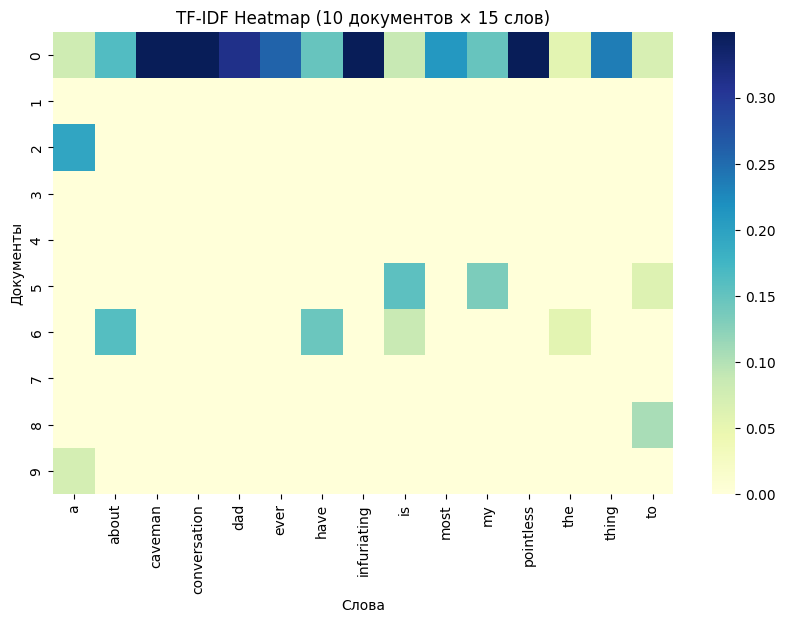

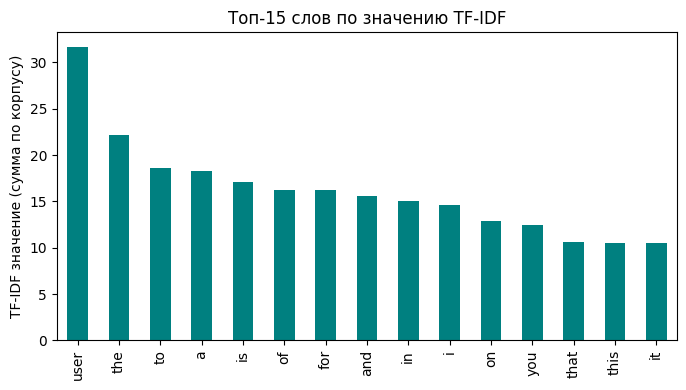

In [20]:
#визуализация
import seaborn as sns
import matplotlib.pyplot as plt

tfidf_df = pd.DataFrame(tfidf_matrix, columns=dictionary.values()) #датафрейм на основе словаря

#таблица частот слов (по сумме TF-IDF)
word_freq = tfidf_df.sum(axis=0).sort_values(ascending=False)
print("Самые частотные слова по TF-IDF:")
display(word_freq.head(10))



# annot=False - не отображать числовые значения в ячейках
plt.figure(figsize=(10, 6))
sns.heatmap(tfidf_df.iloc[:10, :15], cmap="YlGnBu", annot=False) #heatmap для первых 10 документов и первых 15 слов
#cmap="YlGnBu" - цветовая схема от желтого к зеленому и синему
#iloc[:10, :15] - выбирает первые 10 строк и первые 15 колонок (слов)
plt.title("TF-IDF Heatmap (10 строк по 15 слов)")
plt.xlabel("Слова")
plt.ylabel("Строки")
plt.show()

#гистограмма самых частотных слов
plt.figure(figsize=(8, 4))
word_freq.head(15).plot(kind='bar', color='teal')
plt.title("Топ-15 слов по значению TF-IDF")
plt.ylabel("TF-IDF значение (сумма по корпусу)")
plt.show()


In [21]:
def analyze_tfidf_weights(dictionary, bow_corpus, tfidf_corpus):
    """
    Анализирует TF, DF, IDF и TF-IDF веса для каждого слова
    """
    total_docs = len(bow_corpus)

    # 1. вычисляем Document Frequency (DF) - сколько документов содержат слово
    doc_freq = np.zeros(len(dictionary))
    total_occurrences = np.zeros(len(dictionary))

    for doc in bow_corpus:
        for word_id, count in doc:
            doc_freq[word_id] += 1  # увеличиваем счетчик документов для слова
            total_occurrences[word_id] += count  # суммируем общее количество вхождений

    # 2. вычисляем Inverse Document Frequency (IDF) - обратная частота документа
    idf_weights = np.log(total_docs / (doc_freq + 1))  # +1, чтобы не делить на 0
    # IDF - для определения редкости слова

    #создаем DataFrame для результатов
    results = []

    for word_id in range(len(dictionary)):
        word = dictionary[word_id]

        # 3. вычисляем TF (Term Frequency) для каждого документа - частота слова в документе
        tf_by_doc = []
        for doc in bow_corpus:
            tf_score = 0
            for wid, count in doc:
                if wid == word_id:
                    tf_score = count  # заносим частоту для найденного слова
                    break
            tf_by_doc.append(tf_score)

        # 4. вычисляем TF-IDF для каждого документа - итоговая важность слова
        tfidf_by_doc = []
        for doc in tfidf_corpus:
            tfidf_score = 0
            for wid, score in doc:
                if wid == word_id:
                    tfidf_score = score  # извлекаем TF-IDF вес из готовой модели
                    break
            tfidf_by_doc.append(tfidf_score)

        #вычисляем статистики для слова
        avg_tf = np.mean(tf_by_doc)  # средняя частота слова по всем документам
        avg_tfidf = np.mean(tfidf_by_doc)  # средний TF-IDF вес по всем документам
        max_tf = max(tf_by_doc) if any(tf_by_doc) else 0  # максимальная частота в одном документе
        max_tfidf = max(tfidf_by_doc) if any(tfidf_by_doc) else 0  # максимальный TF-IDF в одном документе

        #добавляем все метрики для текущего слова в результаты
        results.append({
            'word_id': word_id,  # идентификатор слова в словаре
            'word': word,  # текстовое представление слова
            'document_frequency': int(doc_freq[word_id]),  # DF - в скольки документах встречается
            'idf': idf_weights[word_id],  # IDF - обратная частота документа
            'total_occurrences': int(total_occurrences[word_id]),  # общее количество вхождений в корпус
            'avg_tf': avg_tf,  # средняя частота термина
            'avg_tfidf': avg_tfidf,  # средний TF-IDF вес (основная метрика важности)
            'max_tf': max_tf,  # максимальная частота в одном документе
            'max_tfidf': max_tfidf,  # максимальный TF-IDF в одном документе
            'documents_with_word_ratio': doc_freq[word_id] / total_docs  # доля документов с этим словом
        })

    return pd.DataFrame(results)

Анализ завершен. Результаты - 'tfidf_analysis.csv'


In [ ]:
#анализ - запускаем функцию для вычисления всех метрик
df_analysis = analyze_tfidf_weights(dictionary, bow_corpus, tfidf_corpus)

#сортируем по TF-IDF для наиболее значимых слов - самые важные слова вверху
df_sorted = df_analysis.sort_values('avg_tfidf', ascending=False)

#сохраняем в CSV
df_sorted.to_csv('tfidf_analysis.csv', index=False, encoding='utf-8-sig')

print("Анализ завершен. Результаты - 'tfidf_analysis.csv'")